In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
DATA_DIR = '/kaggle/input/playground-series-s3e15/'

/kaggle/input/playground-series-s3e15/sample_submission.csv
/kaggle/input/playground-series-s3e15/data.csv
/kaggle/input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from colorama import Style, Fore, Back
## Set Plot Parameters       
plt.style.use("Solarize_Light2")
color_pal = ["#4CAF50", "#780060", "#FFBF00", "#6495ED", "#DE3163",
             "#922710", "#C99BE8", "#FF8700", "#E0FF00", "#2E00FF"]

from category_encoders import OneHotEncoder, MEstimateEncoder, GLMMEncoder, OrdinalEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LogisticRegression
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation
from catboost import CatBoostRegressor
from sklearn import set_config
import gc

import warnings
warnings.filterwarnings('ignore')

set_config(transform_output = 'pandas')

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a class="anchor" id="basic"></a>
#### <p style="padding:5px;background-color:#0047AB;margin:0;color:white;font-family:newtimeroman;font-size:180%;text-align:center;border-radius: 50px 50px;overflow:hidden;font-weight:200">Step 1.2 | Examine data </p>

In [3]:
original = pd.read_csv("/kaggle/input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv")
original.drop(columns = ["id"], inplace=True)

In [4]:
original

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0
...,...,...,...,...,...,...,...,...,...
1860,Richenderfer,plate,1.01,1500,-0.0218,15.0,120.0,10,9.4
1861,Richenderfer,plate,1.01,1500,-0.0434,15.0,120.0,10,10.4
1862,Richenderfer,plate,1.01,2000,-0.0109,15.0,120.0,10,10.8
1863,Richenderfer,plate,1.01,2000,-0.0218,15.0,120.0,10,10.9


In [6]:
data = pd.read_csv(DATA_DIR + "data.csv")
data = data.drop(columns = ["id"])
data = pd.concat([data, original]).reset_index().drop(columns = ["index"])

In [7]:
data

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8
...,...,...,...,...,...,...,...,...,...
33504,Richenderfer,plate,1.01,1500.0,-0.0218,15.0,120.0,10.0,9.4
33505,Richenderfer,plate,1.01,1500.0,-0.0434,15.0,120.0,10.0,10.4
33506,Richenderfer,plate,1.01,2000.0,-0.0109,15.0,120.0,10.0,10.8
33507,Richenderfer,plate,1.01,2000.0,-0.0218,15.0,120.0,10.0,10.9


In [8]:
# https://www.kaggle.com/code/dongjun819/pgs315-eda-lgbm cannot support JSON characters
data = data.rename(columns={'pressure [MPa]': 'pressure', 
                         'mass_flux [kg/m2-s]': 'mass_flux',
                         'x_e_out [-]':'x_e_out',
                         'D_e [mm]': 'D_e',
                         'D_h [mm]': 'D_h',
                         'length [mm]':'length',
                         'chf_exp [MW/m2]':'chf_exp'
                        })

In [9]:
data["x_e_out"].isnull().sum()

10415

In [11]:
#https://www.kaggle.com/code/mohammadrazeghi/p03e15-preprocess-pipeline-baseline-xgboost
def summary(df):
    print(f'{Style.BRIGHT}{Fore.BLACK}Head of the dataset \n \n {"*"*100}')
    display(df.head(3))
    print(f'\n {Style.BRIGHT}{Fore.BLACK}{"*"*100}\n')
    print(f"{Style.BRIGHT}{Fore.BLACK}Summary of the dataset ---->  dataset has {Fore.RED}{df.shape[1]-1}{Fore.BLACK} features and {Fore.RED}{df.shape[0]}{Fore.BLACK} examples.")
    print(f'\n{Style.BRIGHT}{Fore.BLACK}{"*"*100}\n{Style.RESET_ALL}')
    summary = pd.DataFrame(index=df.columns)
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summary["Count"] = desc['count'].values
    summary["Unique"] = df.nunique().values
    summary["Missing"] = df.isnull().sum().values
    summary["Duplicated"] = df.duplicated().sum()
    summary['Std'] = desc['std'].values
    summary["Mode"] = df.mode().values[0]
    summary["Median"] = df.median()
    summary['Mean'] = desc['mean'].values
    summary['Min'] = desc['min'].values
    summary['Max'] = desc['max'].values
    summary["First Value"] = df.loc[0].values
    summary["Last Value"] = df.loc[df.shape[0]-1].values
    summary["Types"] = df.dtypes
    return display(summary)

summary(data)

Head of the dataset 
 
 ****************************************************************************************************


,author,geometry,pressure,mass_flux,x_e_out,D_e,D_h,length,chf_exp
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5



 ****************************************************************************************************

Summary of the dataset ---->  dataset has 8 features and 33509 examples.

****************************************************************************************************



,Count,Unique,Missing,Duplicated,Std,Mode,Median,Mean,Min,Max,First Value,Last Value,Types
author,28485,10,5024,307,NaN,Thompson,NaN,NaN,NaN,NaN,Thompson,Richenderfer,object
geometry,28009,3,5500,307,NaN,tube,NaN,NaN,NaN,NaN,tube,plate,object
pressure,29057.0,144,4452,307,4.333106,13.79,11.0300,10.600324,0.1,20.68,7.0,1.01,float64
mass_flux,28718.0,734,4791,307,1770.14477,4069.0,2729.0000,3054.674351,0.0,7975.0,3770.0,2000.0,float64
x_e_out,23094.0,1702,10415,307,0.102455,0.0334,0.0049,0.00089,-0.8667,0.232,0.1754,-0.0434,float64
D_e,28021.0,43,5488,307,5.273409,10.3,7.8000,8.681699,1.0,37.5,NaN,15.0,float64
D_h,28920.0,50,4589,307,19.93355,10.3,10.3000,14.30288,1.0,120.0,10.8,120.0,float64
length,28750.0,70,4759,307,676.224288,457.0,610.0000,838.070122,10.0,3048.0,432.0,10.0,float64
chf_exp,33509.0,109,0,307,1.984091,2.3,3.4000,3.800194,0.8,19.3,3.6,11.5,float64


In [12]:
cat_cols = data.columns[:2]
num_cols = data.columns[2:]

data.loc[data['D_e'].isna(), 'D_e'] = data.loc[data['D_e'].isna(), 'D_h']
data.loc[data['D_h'].isna(), 'D_h'] = data.loc[data['D_h'].isna(), 'D_e']
data['chf_exp'] = np.log(data['chf_exp'])
data['D_e'] = np.log(data['D_e'])
data['D_h'] = np.log(data['D_h'])
data['length'] = np.log(data['length'])

test = data[data['x_e_out'].isnull()]
train = data[data['x_e_out'].notnull()]

In [ ]:
# check numerical variables' distribution
# https://www.kaggle.com/code/kimtaehun/complete-eda-and-xgb-baseline-guide

features = num_cols
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        train[column], label='Train',
        ax=ax[i], color='#9E3F00'
    )
    
    sns.kdeplot(
        test[column], label='Test',
        ax=ax[i], color='yellow'
    )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Numerical Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()

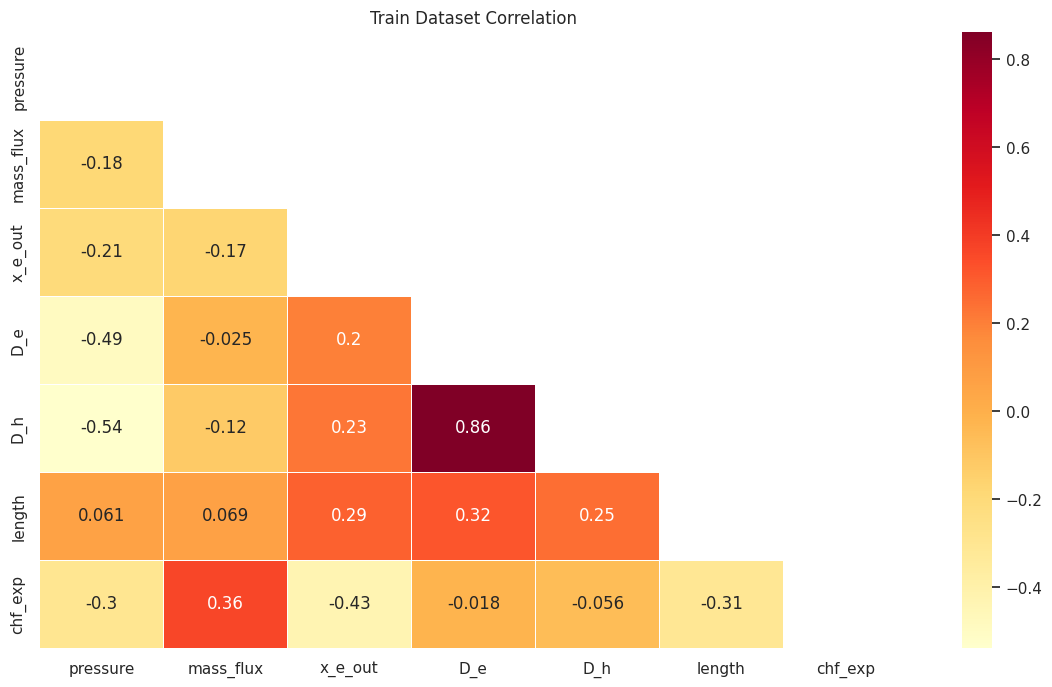

In [14]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(14, 8))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# plot_correlation_heatmap(original, 'Original Dataset Correlation')
plot_correlation_heatmap(train, 'Train Dataset Correlation')

In [15]:
train

,author,geometry,pressure,mass_flux,x_e_out,D_e,D_h,length,chf_exp
0,Thompson,tube,7.00,3770.0,0.1754,2.379546,2.379546,6.068426,1.280934
1,Thompson,tube,NaN,6049.0,-0.0416,2.332144,2.332144,6.635947,1.824549
2,Thompson,NaN,13.79,2034.0,0.0335,2.041220,2.041220,6.124683,0.916291
3,Beus,annulus,13.79,3679.0,-0.0279,1.722767,2.721295,7.665753,1.098612
5,NaN,NaN,17.24,3648.0,-0.0711,0.641854,0.641854,6.545350,1.280934
...,...,...,...,...,...,...,...,...,...
33504,Richenderfer,plate,1.01,1500.0,-0.0218,2.708050,4.787492,2.302585,2.240710
33505,Richenderfer,plate,1.01,1500.0,-0.0434,2.708050,4.787492,2.302585,2.341806
33506,Richenderfer,plate,1.01,2000.0,-0.0109,2.708050,4.787492,2.302585,2.379546
33507,Richenderfer,plate,1.01,2000.0,-0.0218,2.708050,4.787492,2.302585,2.388763


train = train.drop(columns = ["author", "geometry"])
test = test.drop(columns = ["author", "geometry"])

Referenced from https://www.kaggle.com/code/ranjeetshrivastav/heat-flux-catboost-baseline

train['author'].replace(np.nan,'missing',inplace=True)
test['author'].replace(np.nan,'missing',inplace=True)

train['geometry'].replace(np.nan,'missing',inplace=True)
test['geometry'].replace(np.nan,'missing',inplace=True)



In [16]:
from sklearn.impute import SimpleImputer, KNNImputer
m = ['pressure','mass_flux','D_e','D_h','length']
c = ['author', 'geometry']

imputer = KNNImputer(n_neighbors=5) #SimpleImputer(strategy = 'median') KNNImputer(n_neighbors=5)
imputer_c = SimpleImputer(strategy='most_frequent')

train[m] = imputer.fit_transform(train[m])
test[m] = imputer.transform(test[m])
train[c] = imputer_c.fit_transform(train[c])
test[c] = imputer_c.transform(test[c])

In [17]:
train = pd.get_dummies(train, drop_first = True)
test = pd.get_dummies(test, drop_first = True)

In [18]:
y_train = train['x_e_out'].copy()
train = train.drop(columns = ['x_e_out'])
test = test.drop(columns = ['x_e_out'])

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(verbose=2)

train = imp.fit_transform(train)
test = imp.fit_transform(test)

In [19]:
#train = train.drop(columns = ['x_e_out'])

In [20]:
train

,pressure,mass_flux,D_e,D_h,length,chf_exp,author_Inasaka,author_Janssen,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,geometry_plate,geometry_tube
0,7.00,3770.0,2.379546,2.379546,6.068426,1.280934,0,0,0,0,0,0,1,0,0,0,1
1,6.89,6049.0,2.332144,2.332144,6.635947,1.824549,0,0,0,0,0,0,1,0,0,0,1
2,13.79,2034.0,2.041220,2.041220,6.124683,0.916291,0,0,0,0,0,0,1,0,0,0,1
3,13.79,3679.0,1.722767,2.721295,7.665753,1.098612,0,0,0,0,0,0,0,0,0,0,0
5,17.24,3648.0,0.641854,0.641854,6.545350,1.280934,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33504,1.01,1500.0,2.708050,4.787492,2.302585,2.240710,0,0,0,0,0,1,0,0,0,1,0
33505,1.01,1500.0,2.708050,4.787492,2.302585,2.341806,0,0,0,0,0,1,0,0,0,1,0
33506,1.01,2000.0,2.708050,4.787492,2.302585,2.379546,0,0,0,0,0,1,0,0,0,1,0
33507,1.01,2000.0,2.708050,4.787492,2.302585,2.388763,0,0,0,0,0,1,0,0,0,1,0


In [21]:
test

,pressure,mass_flux,D_e,D_h,length,chf_exp,author_Inasaka,author_Janssen,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,geometry_plate,geometry_tube
4,13.790,686.0,2.406945,2.406945,6.124683,1.029619,0,0,0,0,0,0,1,0,0,0,1
7,18.000,750.0,2.302585,2.302585,7.408531,0.788457,0,0,0,0,1,0,0,0,0,0,1
10,15.514,3098.2,0.641854,0.641854,5.023881,1.163151,0,0,0,0,0,0,1,0,0,0,1
12,6.890,7500.0,2.549445,2.549445,7.565275,1.568616,0,0,0,0,0,0,1,0,0,0,1
23,15.510,1355.0,1.722767,2.721295,7.665753,0.741937,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31633,11.030,3125.2,2.442347,2.442347,7.076848,0.693147,0,0,0,0,0,0,1,0,0,0,1
31634,1.010,2000.0,2.708050,4.787492,2.302585,1.824549,0,0,0,0,0,1,0,0,0,1,0
31637,13.790,688.0,2.406945,2.406945,6.124683,0.832909,0,0,0,0,0,0,0,1,0,0,1
31640,13.790,5298.2,1.547563,1.547563,5.753703,1.360977,0,0,0,0,0,0,1,0,0,0,1


In [24]:
X_train = train #.drop(columns=['x_e_out'])
X_test = test#.drop(columns=['id'])
#y_train = train['x_e_out'].copy()

params = {'metric': 'rmse',"random_state":123,
          'objective':'regression_l1', 'colsample_bytree': .4, 
          'verbosity': -1,'n_jobs': -1,"n_estimators":500,
          'learning_rate': 0.06,'subsample': .5, 'num_iterations':1000
         }

NFOLDS = 10
FACTOR = 0.8

#for FACTOR in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
print(f"Weight {Fore.CYAN}{FACTOR} {Fore.BLACK} to CatBoost --->")
folds = KFold(n_splits=10, shuffle = True, random_state = 123)

splits = folds.split(X_train, y_train)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0
for fold_n, (train_index, valid_index) in enumerate(splits):

    #--------------------------------CATBOOST--------------------------------------------

    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]
    catboost_reg = CatBoostRegressor(loss_function = "RMSE", random_state=123, \
                                     cat_features=[], early_stopping_rounds=200, iterations=1000, \
                                     grow_policy="Lossguide", max_leaves=41, verbose=False)
    catboost_reg.fit(X_tr, y_tr, eval_set=(X_val, y_val), silent=True)
    y_pred_valid_cat = catboost_reg.predict(X_val)
    y_pred_train_cat = catboost_reg.predict(X_tr)

    #--------------------------------LIGHTGBM--------------------------------------------

    lightgbm_reg = LGBMRegressor(**params, verbose=-1)
    lightgbm_reg.fit(X_tr, y_tr, eval_set=(X_val, y_val), 
                     callbacks=[early_stopping(stopping_rounds=100), log_evaluation(period=0)])
    y_pred_valid_lgbm = lightgbm_reg.predict(X_val)
    y_pred_train_lgbm = lightgbm_reg.predict(X_tr)

    #--------------------------------COMBINED--------------------------------------------
    y_pred_valid = (FACTOR * y_pred_valid_cat) + ((1 - FACTOR) * y_pred_valid_lgbm)
    y_pred_train = (FACTOR * y_pred_train_cat) + ((1 - FACTOR) * y_pred_train_lgbm)
    y_oof[valid_index] = y_pred_valid

    print(f"Fold {fold_n + 1} | Train RMSE | {mean_squared_error(y_tr, y_pred_train, squared=False)}")

    print(f"Fold {fold_n + 1} | RMSE: {mean_squared_error(y_val, y_pred_valid, squared=False)}")
    score += mean_squared_error(y_val, y_pred_valid, squared=False) / NFOLDS

    # Predict the test set
    cur_preds = (FACTOR * catboost_reg.predict(X_test)) + ((1 - FACTOR) * lightgbm_reg.predict(X_test))
    y_preds += cur_preds / NFOLDS
    del X_tr, X_val, y_tr, y_val
    gc.collect()

print(f"\nMean RMSE = {Fore.LIGHTMAGENTA_EX}{score}{Fore.BLACK}")
print(f"Out of folds RMSE = {Fore.GREEN}{mean_squared_error(y_train, y_oof, squared=False)}{Fore.BLACK}")

Weight 0.8  to CatBoost --->
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[631]	valid_0's rmse: 0.0748041
Fold 1 | Train RMSE | 0.06612183695210844
Fold 1 | RMSE: 0.07289352016546517
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[283]	valid_0's rmse: 0.079469
Fold 2 | Train RMSE | 0.06894494026399303
Fold 2 | RMSE: 0.07812379910412001
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[818]	valid_0's rmse: 0.0768697
Fold 3 | Train RMSE | 0.06784749904115202
Fold 3 | RMSE: 0.07577427683850937
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be

weights = Ridge(random_state = 123, positive = True, fit_intercept = True).fit(X = oof_list, y = y).coef_

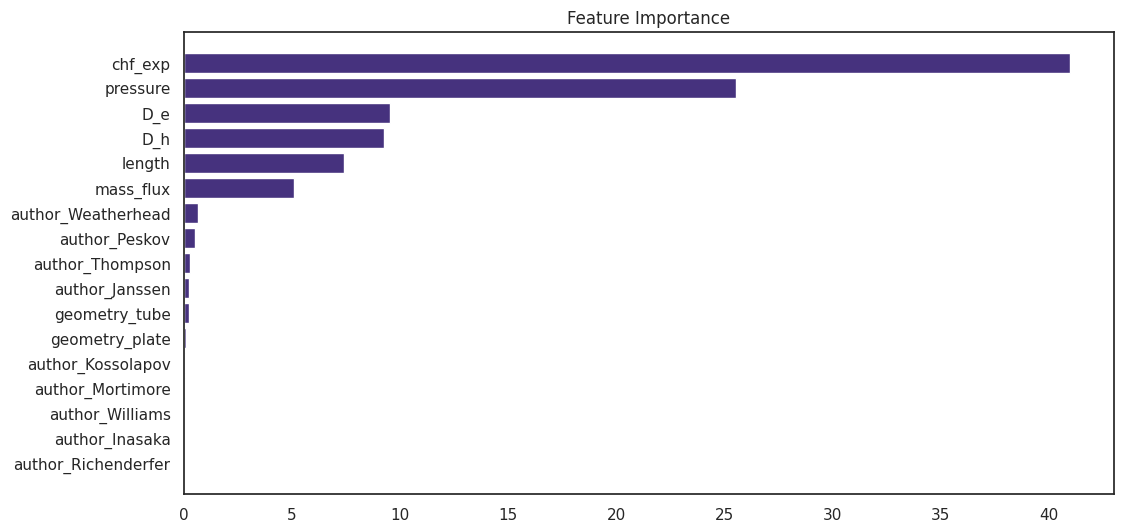

In [26]:
feature_importance = catboost_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [27]:
sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')
sub['x_e_out [-]'] = y_preds
sub.to_csv('submission.csv',index=False)
sub

,id,x_e_out [-]
0,4,-0.004026
1,7,-0.096077
2,10,-0.044240
3,12,-0.002426
4,23,0.039594
...,...,...
10410,31633,0.078007
10411,31634,-0.042185
10412,31637,0.027751
10413,31640,-0.070163
